## **DETECCION DE PLAGAS EN LAS HOJAS DE MAIZ APLICANDO VISION COMPUTACIONAL**
* Cristhian Ccala Huamani

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt 
from PIL import Image
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## **Direccion de Datos**

In [11]:
dr_file_train = './DataSet_Entrenamiento'
dr_file_valid = './DataSet_Validacion'

In [12]:
dr_img_train = []
label_train = []
for file in os.listdir(dr_file_train):
    for img in os.listdir(f"{dr_file_train}/{file}"):
        dr_img_train.append(f"{dr_file_train}/{file}/{img}")
        label_train.append(file)

dr_img_valid = []
label_valid = []
for file in os.listdir(dr_file_valid):
    for img in os.listdir(f"{dr_file_valid}/{file}"):
        dr_img_valid.append(f"{dr_file_valid}/{file}/{img}")
        label_valid.append(file)

In [13]:
train = pd.DataFrame({'dr_img':dr_img_train, 'label':label_train})
train

,dr_img,label
0,./DataSet_Entrenamiento/Blight/Corn_Blight (1)...,Blight
1,./DataSet_Entrenamiento/Blight/Corn_Blight (1)...,Blight
2,./DataSet_Entrenamiento/Blight/Corn_Blight (10...,Blight
3,./DataSet_Entrenamiento/Blight/Corn_Blight (10...,Blight
4,./DataSet_Entrenamiento/Blight/Corn_Blight (10...,Blight
...,...,...
3355,./DataSet_Entrenamiento/Healthy/Corn_Health (9...,Healthy
3356,./DataSet_Entrenamiento/Healthy/Corn_Health (9...,Healthy
3357,./DataSet_Entrenamiento/Healthy/Corn_Health (9...,Healthy
3358,./DataSet_Entrenamiento/Healthy/Corn_Health (9...,Healthy


In [14]:
valid = pd.DataFrame({'dr_img':dr_img_valid, 'label':label_valid})
valid

,dr_img,label
0,./DataSet_Validacion/Blight/Corn_Blight (1000)...,Blight
1,./DataSet_Validacion/Blight/Corn_Blight (1001)...,Blight
2,./DataSet_Validacion/Blight/Corn_Blight (1002)...,Blight
3,./DataSet_Validacion/Blight/Corn_Blight (1003)...,Blight
4,./DataSet_Validacion/Blight/Corn_Blight (1004)...,Blight
...,...,...
823,./DataSet_Validacion/Healthy/Corn_Health (995)...,Healthy
824,./DataSet_Validacion/Healthy/Corn_Health (996)...,Healthy
825,./DataSet_Validacion/Healthy/Corn_Health (997)...,Healthy
826,./DataSet_Validacion/Healthy/Corn_Health (998)...,Healthy


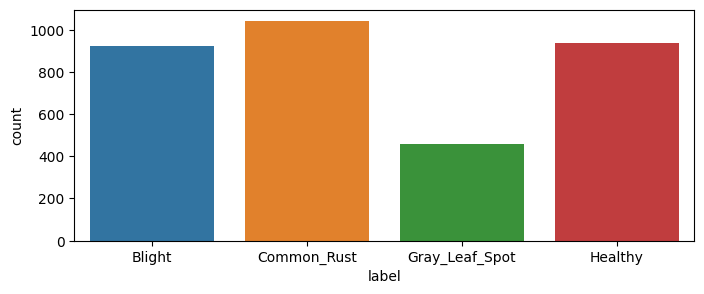

In [15]:
plt.figure(figsize = (8,3))
sns.countplot(x='label', data=train)
plt.show()

In [16]:
etiquetas = train.label.unique()
etiquetas

array(['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'], dtype=object)

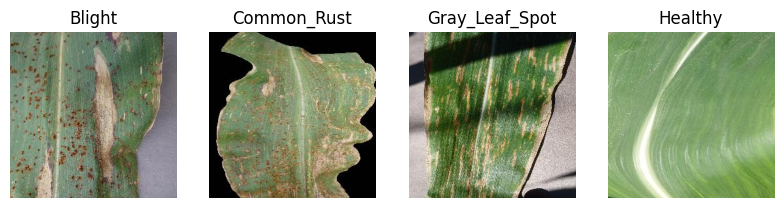

In [17]:
# Visualizamos las diferentes variedades de tuberculos
plt.figure(figsize = (15,14))
for i,j in enumerate(etiquetas):
    dt = train[train['label'] == j].sample(n=1).values
    img = Image.open(dt[0][0])
    plt.subplot(5,6,i+1)
    plt.imshow(img)
    plt.title(dt[0][1])
    plt.axis("off")


## **Eliminar columnas Innecesarias**

In [18]:
target_train = train['label']
train = train.drop(['label'], axis=1)

target_valid = valid['label']
valid = valid.drop(['label'], axis=1)

In [19]:
indices = dict(zip(etiquetas, range(len(etiquetas))))
labels_num = list(map(indices.get, target_train.values))
target_train = tf.keras.utils.to_categorical(labels_num, num_classes=len(etiquetas))

In [20]:
indices = dict(zip(etiquetas, range(len(etiquetas))))
labels_num = list(map(indices.get, target_valid.values))
target_valid = tf.keras.utils.to_categorical(labels_num, num_classes=len(etiquetas))

## **Dividir Datos**

In [21]:
x_train = train.dr_img
y_train = target_train

x_valid = train.dr_img
y_valid = target_valid

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(3360,)
(3360,)
(3360, 4)
(828, 4)


In [22]:
# Creamos una funcion para leer las imagenes
def read_imagen(path):
    file = tf.io.read_file(path)
    image = tf.io.decode_png(file, 3)
    image = tf.image.resize(image, [256, 256])
    return image

In [23]:
# apartir de la division creamos un conjunto de datos a partir de tensores
X_train = tf.data.Dataset.from_tensor_slices(x_train).map(read_imagen, num_parallel_calls=tf.data.AUTOTUNE)
Y_train = tf.data.Dataset.from_tensor_slices(y_train)
X_valid = tf.data.Dataset.from_tensor_slices(x_valid).map(read_imagen, num_parallel_calls=tf.data.AUTOTUNE)
Y_valid = tf.data.Dataset.from_tensor_slices(y_valid)
# combinamos dos conjuntos de datos elemento por elemento para crear un nuevo conjunto de datos
ds_train = tf.data.Dataset.zip((X_train, Y_train))
ds_valid = tf.data.Dataset.zip((X_valid, Y_valid))

In [24]:
# Normalizamos los datos apartir de la libreria de tensorflow
normalizar_data = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1/255.)
])
# tranformaremos los datos aleatoriamente por si tengamos imagenes repetidas
data_augmenation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    tf.keras.layers.RandomFlip(mode = "vertical")
])

In [25]:
# Aplicamos la Normalizacion y transformacion a los datos
ds_train = ds_train.map(lambda x, y: (normalizar_data(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# mezaclamos los datos y convertimos los datos en lotes tanto como para el entrenamiento y validacion
ds_train = ds_train.shuffle(1000)
ds_train = ds_train.batch(8)
ds_train = ds_train.map(lambda x, y: (data_augmenation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

ds_valid = ds_valid.map(lambda x, y: (normalizar_data(x), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.batch(8)

# cargamos los datos de forma asíncrona para mejorar el rendimiento del entrenamiento y la validación
entrenar_ds = ds_train.prefetch(buffer_size=tf.data.AUTOTUNE) 
validar_ds = ds_valid.prefetch(buffer_size=tf.data.AUTOTUNE) 

## **Modelo**

Alexnet

In [16]:
alexnet_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    tf.keras.layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
])

alexnet_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

# entrenamos en modelo con 6 epocas
historia_alexnet = alexnet_model.fit(
    entrenar_ds,
    epochs = 10,
    validation_data= validar_ds
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  2/419 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.1250 - loss: 1.3902 - precision: 0.0000e+00 - recall: 0.0000e+00   

I0000 00:00:1722221272.165514     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722221272.194274     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5913 - loss: 0.9105 - precision: 0.7453 - recall: 0.4202

W0000 00:00:1722221295.213334     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722221296.302083     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.5916 - loss: 0.9099 - precision: 0.7455 - recall: 0.4207 - val_accuracy: 0.8282 - val_loss: 0.4714 - val_precision: 0.8517 - val_recall: 0.7947
Epoch 2/10


W0000 00:00:1722221298.784397     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.8236 - loss: 0.4790 - precision: 0.8509 - recall: 0.7799 - val_accuracy: 0.8413 - val_loss: 0.3863 - val_precision: 0.8673 - val_recall: 0.8115
Epoch 3/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.8392 - loss: 0.4115 - precision: 0.8758 - recall: 0.8001 - val_accuracy: 0.8484 - val_loss: 0.3840 - val_precision: 0.8766 - val_recall: 0.8222
Epoch 4/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.8774 - loss: 0.3374 - precision: 0.8982 - recall: 0.8503 - val_accuracy: 0.8508 - val_loss: 0.3837 - val_precision: 0.8606 - val_recall: 0.8401
Epoch 5/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.8656 - loss: 0.3279 - precision: 0.8981 - recall: 0.8371 - val_accuracy: 0.8484 - val_loss: 0.3670 - val_precision: 0.8787 - val_recall: 0.8210
Epoch 6/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.8792 - loss: 0.2987 - precision: 0.9038 - recall: 0.8520 - val_accuracy: 0.8628 - val_loss: 0.3

VGG

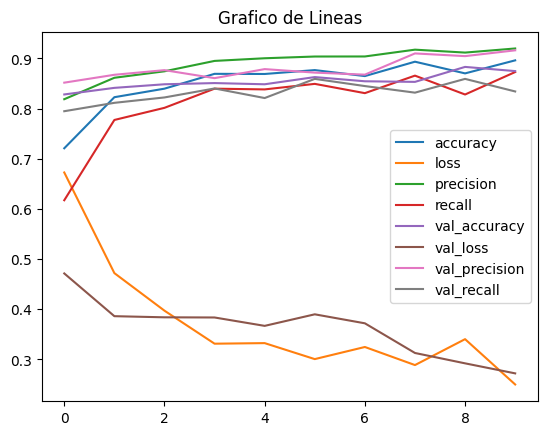

In [30]:
pd.DataFrame(historia_alexnet.history).plot()
plt.title('Grafico de Lineas')
plt.show()

In [17]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)
vgg16_o = tf.keras.layers.Flatten()(vgg16.output)
vgg16_o = tf.keras.layers.Dense(4096, activation='relu')(vgg16_o)
vgg16_o = tf.keras.layers.Dense(4, activation='softmax')(vgg16_o) 

vgg16_model = tf.keras.models.Model(inputs=vgg16.input, outputs=vgg16_o)
vgg16_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

# entrenamos en modelo con 6 epocas
historia_vgg16 = vgg16_model.fit(
    entrenar_ds,
    epochs = 10,
    validation_data= validar_ds
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


W0000 00:00:1722221514.985298     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


418/419 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5003 - loss: 1.1805 - precision_1: 0.6281 - recall_1: 0.3029

W0000 00:00:1722221641.936863     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5007 - loss: 1.1798 - precision_1: 0.6284 - recall_1: 0.3034

W0000 00:00:1722221643.347886     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 190s 323ms/step - accuracy: 0.5010 - loss: 1.1790 - precision_1: 0.6288 - recall_1: 0.3039 - val_accuracy: 0.8007 - val_loss: 0.4637 - val_precision_1: 0.8311 - val_recall_1: 0.7399
Epoch 2/10


W0000 00:00:1722221650.207913     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 90s 213ms/step - accuracy: 0.8044 - loss: 0.4551 - precision_1: 0.8294 - recall_1: 0.7814 - val_accuracy: 0.7578 - val_loss: 0.6189 - val_precision_1: 0.8234 - val_recall_1: 0.6563
Epoch 3/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 90s 212ms/step - accuracy: 0.8047 - loss: 0.4518 - precision_1: 0.8348 - recall_1: 0.7760 - val_accuracy: 0.7840 - val_loss: 0.4444 - val_precision_1: 0.8069 - val_recall_1: 0.7482
Epoch 4/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 90s 211ms/step - accuracy: 0.8101 - loss: 0.4290 - precision_1: 0.8340 - recall_1: 0.7796 - val_accuracy: 0.8091 - val_loss: 0.4255 - val_precision_1: 0.8167 - val_recall_1: 0.7924
Epoch 5/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 90s 211ms/step - accuracy: 0.8448 - loss: 0.3592 - precision_1: 0.8676 - recall_1: 0.8236 - val_accuracy: 0.8520 - val_loss: 0.3698 - val_precision_1: 0.8641 - val_recall_1: 0.8425
Epoch 6/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 90s 211ms/step - accuracy: 0.8510 - loss: 0.3345 - precision_1: 0.8729 - recall_1: 0.83

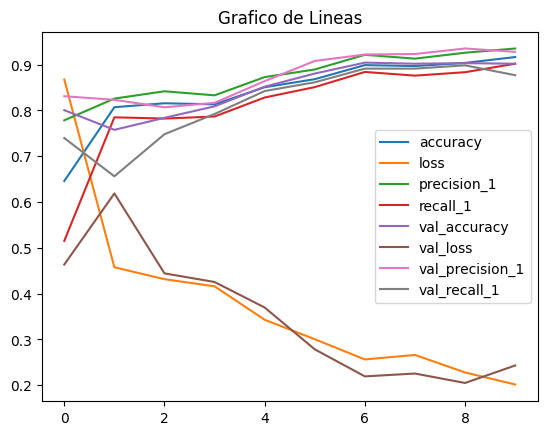

In [31]:
pd.DataFrame(historia_vgg16.history).plot()
plt.title('Grafico de Lineas')
plt.show()

In [18]:
from tensorflow.keras.applications import VGG19

vgg19 = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)
vgg19_o = tf.keras.layers.Flatten()(vgg19.output)
vgg19_o = tf.keras.layers.Dense(4096, activation='relu')(vgg19_o)
vgg19_o = tf.keras.layers.Dense(4, activation='softmax')(vgg19_o) 

vgg19_model = tf.keras.models.Model(inputs=vgg19.input, outputs=vgg19_o)
vgg19_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

#vgg19_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# entrenamos en modelo con 6 epocas
historia_vgg19 = vgg19_model.fit(
    entrenar_ds,
    epochs = 10,
    validation_data= validar_ds
)

Epoch 1/10


W0000 00:00:1722222468.101318     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


418/419 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.3908 - loss: 1.3490 - precision_2: 0.5490 - recall_2: 0.1239

W0000 00:00:1722222569.222175     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.3910 - loss: 1.3485 - precision_2: 0.5494 - recall_2: 0.1242

W0000 00:00:1722222570.720222     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 120s 265ms/step - accuracy: 0.3911 - loss: 1.3480 - precision_2: 0.5498 - recall_2: 0.1245 - val_accuracy: 0.5346 - val_loss: 0.9500 - val_precision_2: 0.8011 - val_recall_2: 0.5095
Epoch 2/10


W0000 00:00:1722222579.053933     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 106s 250ms/step - accuracy: 0.6717 - loss: 1.1475 - precision_2: 0.8124 - recall_2: 0.5317 - val_accuracy: 0.8019 - val_loss: 0.4571 - val_precision_2: 0.8053 - val_recall_2: 0.7947
Epoch 3/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 106s 250ms/step - accuracy: 0.8110 - loss: 0.4767 - precision_2: 0.8308 - recall_2: 0.7774 - val_accuracy: 0.7900 - val_loss: 0.4681 - val_precision_2: 0.7973 - val_recall_2: 0.7792
Epoch 4/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 106s 249ms/step - accuracy: 0.8351 - loss: 0.4025 - precision_2: 0.8542 - recall_2: 0.8136 - val_accuracy: 0.8329 - val_loss: 0.4070 - val_precision_2: 0.8610 - val_recall_2: 0.7983
Epoch 5/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 106s 249ms/step - accuracy: 0.8342 - loss: 0.3865 - precision_2: 0.8591 - recall_2: 0.8109 - val_accuracy: 0.8258 - val_loss: 0.4024 - val_precision_2: 0.8339 - val_recall_2: 0.8150
Epoch 6/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 105s 249ms/step - accuracy: 0.8438 - loss: 0.3730 - precision_2: 0.8636 - recall_2:

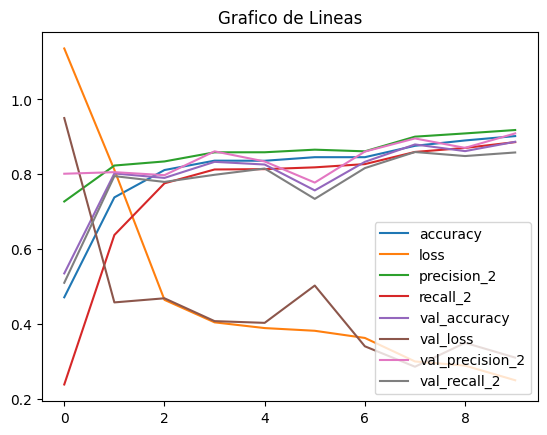

In [32]:
pd.DataFrame(historia_vgg19.history).plot()
plt.title('Grafico de Lineas')
plt.show()

Inception

In [20]:
from tensorflow.keras.applications import InceptionV3

inceptionv3 = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)
inceptionv3_o = tf.keras.layers.Flatten()(inceptionv3.output)
inceptionv3_o = tf.keras.layers.Dense(4096, activation='relu')(inceptionv3_o)
inceptionv3_o = tf.keras.layers.Dense(4, activation='softmax')(inceptionv3_o) 
inceptionv3_model = tf.keras.models.Model(inputs=inceptionv3.input, outputs=inceptionv3_o)

inceptionv3_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
# entrenamos en modelo con 6 epocas
historia_inceptionv3 = inceptionv3_model.fit(
    entrenar_ds,
    epochs = 10,
    validation_data= validar_ds
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
  1/419 ━━━━━━━━━━━━━━━━━━━━ 11:18:05 97s/step - accuracy: 0.1250 - loss: 1.6957 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00

W0000 00:00:1722223629.188423     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6416 - loss: 7.3427 - precision_3: 0.6801 - recall_3: 0.6008

W0000 00:00:1722223754.491126     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722223761.295441     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 237s 334ms/step - accuracy: 0.6418 - loss: 7.3303 - precision_3: 0.6803 - recall_3: 0.6010 - val_accuracy: 0.8592 - val_loss: 0.3842 - val_precision_3: 0.9133 - val_recall_3: 0.7924
Epoch 2/10


W0000 00:00:1722223769.063286     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


419/419 ━━━━━━━━━━━━━━━━━━━━ 77s 181ms/step - accuracy: 0.8405 - loss: 0.5136 - precision_3: 0.8842 - recall_3: 0.7903 - val_accuracy: 0.8282 - val_loss: 0.5071 - val_precision_3: 0.8526 - val_recall_3: 0.8007
Epoch 3/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 77s 180ms/step - accuracy: 0.8498 - loss: 0.4578 - precision_3: 0.8822 - recall_3: 0.8168 - val_accuracy: 0.7912 - val_loss: 0.8454 - val_precision_3: 0.8092 - val_recall_3: 0.7745
Epoch 4/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 77s 180ms/step - accuracy: 0.8818 - loss: 0.3222 - precision_3: 0.9108 - recall_3: 0.8540 - val_accuracy: 0.8246 - val_loss: 0.5103 - val_precision_3: 0.8579 - val_recall_3: 0.8067
Epoch 5/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 76s 180ms/step - accuracy: 0.8950 - loss: 0.2640 - precision_3: 0.9292 - recall_3: 0.8668 - val_accuracy: 0.8938 - val_loss: 0.3357 - val_precision_3: 0.9074 - val_recall_3: 0.8771
Epoch 6/10
419/419 ━━━━━━━━━━━━━━━━━━━━ 77s 180ms/step - accuracy: 0.8913 - loss: 0.3105 - precision_3: 0.9267 - recall_3: 0.86

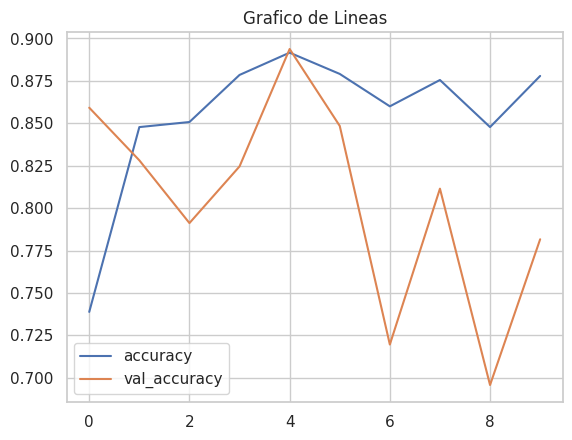

In [59]:
pd.DataFrame(historia_inceptionv3.history)[['accuracy','val_accuracy']].plot()
plt.title('Grafico de Lineas')
plt.show()

## **Evaluar Modelo**

In [25]:
m1 = alexnet_model.evaluate(validar_ds)
m2 = vgg16_model.evaluate(validar_ds)
m3 = vgg19_model.evaluate(validar_ds)
m4 = inceptionv3_model.evaluate(validar_ds)

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8701 - loss: 0.2640 - precision: 0.9160 - recall: 0.8414
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9015 - loss: 0.2143 - precision_1: 0.9392 - recall_1: 0.8763
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.9034 - loss: 0.2709 - precision_2: 0.9256 - recall_2: 0.8736
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7754 - loss: 20.0000 - precision_3: 0.7921 - recall_3: 0.7631


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


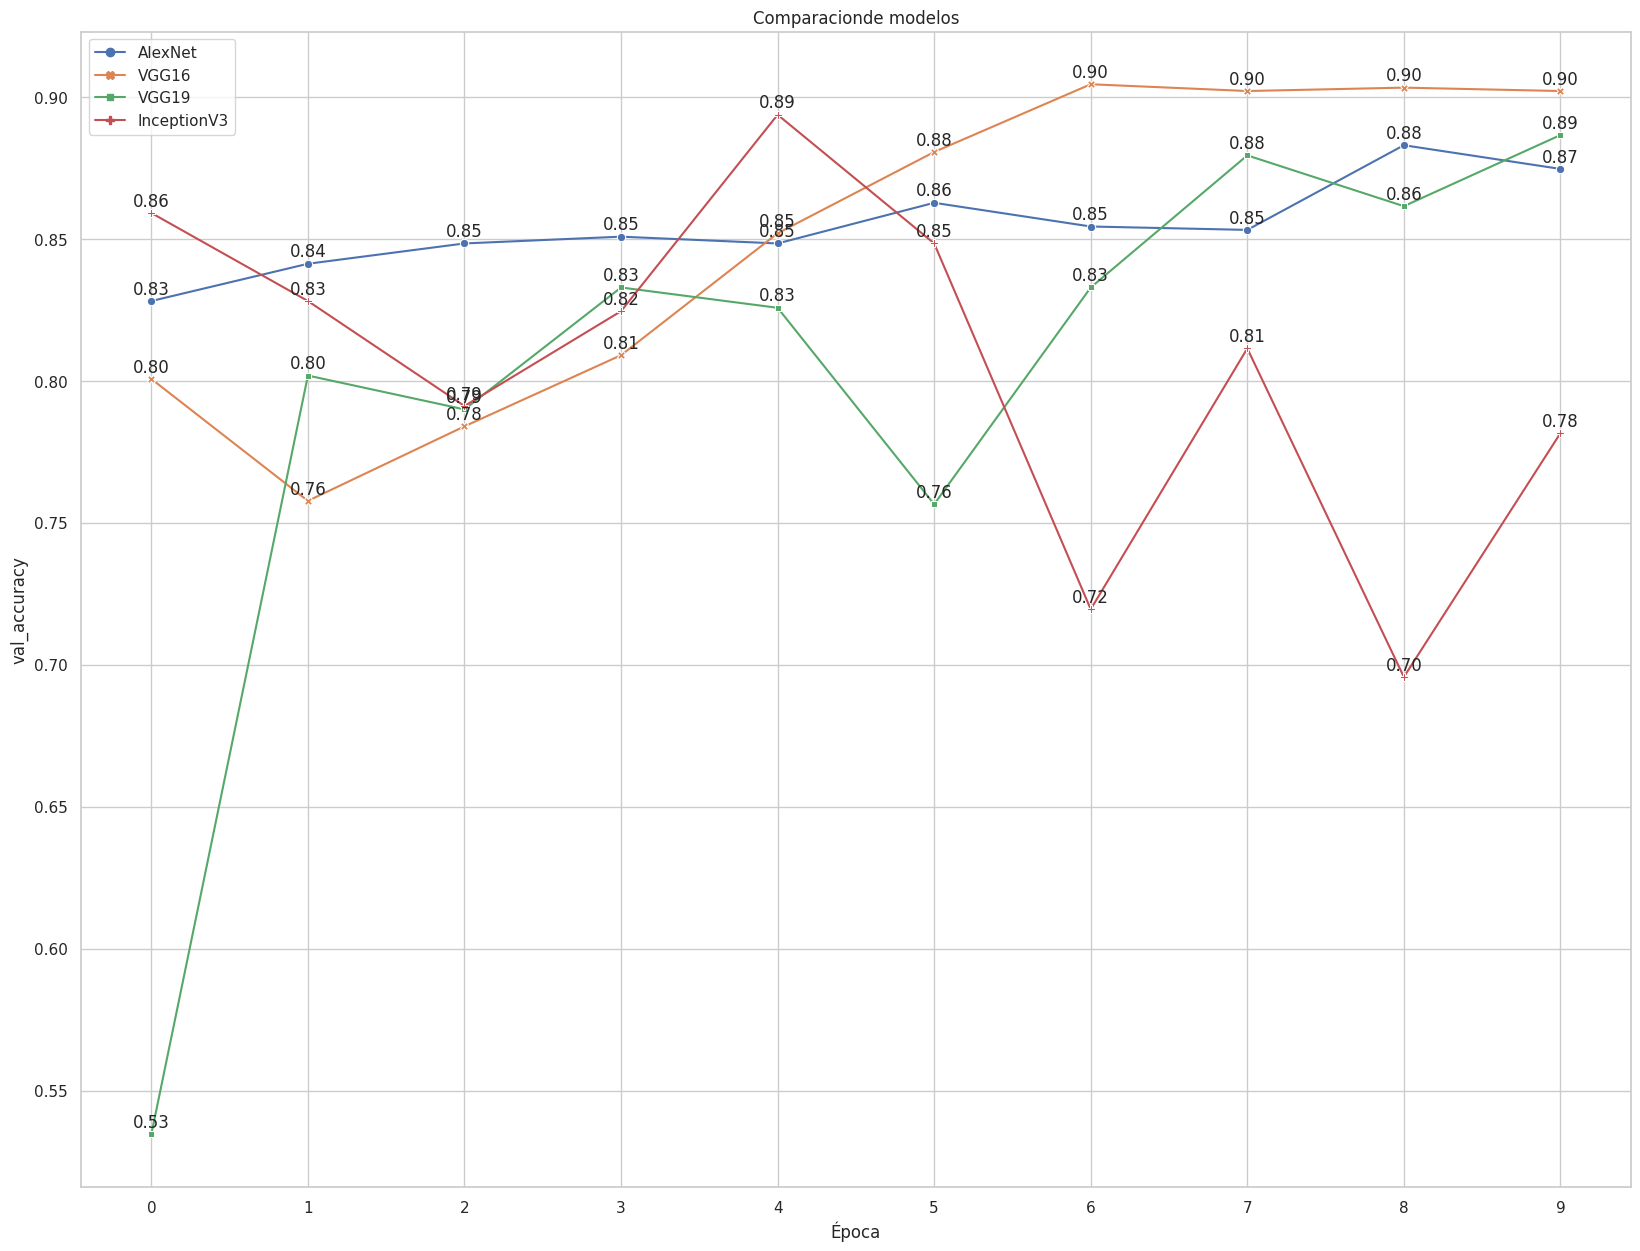

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Crear un DataFrame con los valores de val_accuracy para cada modelo
historia_df = pd.DataFrame({
    'AlexNet': historia_alexnet.history['val_accuracy'],
    'VGG16': historia_vgg16.history['val_accuracy'],
    'VGG19': historia_vgg19.history['val_accuracy'],
    'InceptionV3': historia_inceptionv3.history['val_accuracy']
})

# Ajustar el tamaño de la figura
plt.figure(figsize=(20, 15))

# Graficar el historial de val_accuracy con seaborn
sns.lineplot(data=historia_df, markers=True, dashes=False)

# Añadir título y etiquetas
plt.title('Comparacionde modelos')
plt.xlabel('Época')
plt.ylabel('val_accuracy')
plt.grid(True)

# Añadir anotaciones en cada punto de datos
for model in ['AlexNet', 'VGG16', 'VGG19', 'InceptionV3']:
    for epoch, accuracy in enumerate(historia_df[model]):
        plt.annotate(f'{accuracy:.2f}', (epoch, accuracy), textcoords="offset points", xytext=(0,5), ha='center')

# Mostrar el gráfico
plt.xticks(range(len(historia_df)))
plt.savefig('val_accuracy_plot.png', bbox_inches='tight')
plt.show()



In [85]:
historia_df

,AlexNet,VGG16,VGG19,InceptionV3
0,0.828162,0.800716,0.534606,0.859189
1,0.841289,0.757757,0.801909,0.828162
2,0.848449,0.784010,0.789976,0.791169
3,0.850835,0.809069,0.832936,0.824582
4,0.848449,0.852029,0.825776,0.893795
5,0.862768,0.880668,0.756563,0.848449
6,0.854415,0.904535,0.832936,0.719570
7,0.853222,0.902148,0.879475,0.811456
8,0.883055,0.903341,0.861575,0.695704
9,0.874702,0.902148,0.886635,0.781623


In [29]:
Resultados = pd.DataFrame({
    'Modelos':['AlexNet','VGG16','VGG19','InceptionV3'],
    'Accuracy':[m1[1], m2[1], m3[1], m4[1]],
    'Precision':[m1[2], m2[2], m3[2], m4[2]],
    'Recall':[m1[3], m2[3], m3[3], m4[3]],
    'Loss':[m1[0], m2[0], m3[0], m4[0]]
})
Resultados

,Modelos,Accuracy,Precision,Recall,Loss
0,AlexNet,0.874702,0.916121,0.834129,0.272274
1,VGG16,0.902148,0.928030,0.877088,0.243299
2,VGG19,0.886635,0.908976,0.857995,0.309507
3,InceptionV3,0.781623,0.799751,0.767303,18.201782
